In [ ]:
# make torch imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable as Var

# make other relevant imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Define the NN
class NN(nn.Module):

  def __init__(self):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(3, 40) # Fully connected layers
    self.fc2 = nn.Linear(40, 60)
    self.fc3 = nn.Linear(60, 120)
    self.fc4 = nn.Linear(120, 120)
    self.fc5 = nn.Linear(120, 120)
    self.fc6 = nn.Linear(120, 60)
    self.fc7 = nn.Linear(60, 40)
    self.fc8 = nn.Linear(40, 3)

  def forward(self, phi):
    phi.requires_grad=True
    # forward pass
    y = torch.sin(self.fc1(phi))
    y = torch.sin(self.fc2(y))
    y = torch.sin(self.fc3(y))
    y = torch.sin(self.fc4(y))
    y = torch.sin(self.fc5(y))
    y = torch.sin(self.fc6(y))
    y = self.fc7(y)
    kappa = self.fc8(y)

    # compute jacobian

    return kappa


In [ ]:
# Import input and output targets
# limits are hard-coded (for now at least)
inputs = pd.read_csv('EffectiveParameter.csv')
targets = pd.read_csv('EigenValues.csv')

# train on 2700 samples
training_set = inputs.iloc[0:2700, :].values * 10
training_target = targets.iloc[0:2700, :].values * 100

# validation on 300 samples
validation_set = inputs.iloc[2700:3000, :].values * 10
validation_target = targets.iloc[2700:3000, :].values * 100

In [ ]:
# inputs and targets
training_set = torch.from_numpy(training_set)
training_target = torch.from_numpy(training_target)

validation_set = torch.from_numpy(validation_set)
validation_target = torch.from_numpy(validation_target)

# set to Variable for training
training_set, training_target = Var(training_set), Var(training_target)

# initialize model
model = NN()

# define loss criterion
criterion = nn.MSELoss(reduction='mean')

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01, amsgrad=False)

model = torch.load('trained_net')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.00001, amsgrad=False)

In [ ]:
# training
model.train()
model.double()

for time in range(10000):
  kappa_pred = model(training_set)

  loss = criterion(kappa_pred, training_target)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if time%100 == 0:
    print("Epoch: {}, Loss: {}".format(time, loss.item()))


Epoch: 0, Loss: 2.8171934273481745e-05
Epoch: 100, Loss: 2.7721359301586948e-05
Epoch: 200, Loss: 2.74169091303072e-05
Epoch: 300, Loss: 2.7035742277913645e-05
Epoch: 400, Loss: 2.661994751845615e-05
Epoch: 500, Loss: 2.6182839674480338e-05
Epoch: 600, Loss: 2.573115013190801e-05
Epoch: 700, Loss: 2.52779241941943e-05
Epoch: 800, Loss: 2.4823952270903644e-05
Epoch: 900, Loss: 2.438774447292176e-05
Epoch: 1000, Loss: 2.3975959271258395e-05
Epoch: 1100, Loss: 2.353675367012702e-05
Epoch: 1200, Loss: 2.3127372843207562e-05
Epoch: 1300, Loss: 2.2728326192525966e-05
Epoch: 1400, Loss: 2.2406141014347137e-05
Epoch: 1500, Loss: 2.1965355053664004e-05
Epoch: 1600, Loss: 2.162642829022855e-05
Epoch: 1700, Loss: 2.1256085904463072e-05
Epoch: 1800, Loss: 2.0922554783326464e-05
Epoch: 1900, Loss: 2.0598800035994292e-05
Epoch: 2000, Loss: 2.0287604978420178e-05
Epoch: 2100, Loss: 1.9989268909767122e-05
Epoch: 2200, Loss: 1.9702378843457634e-05
Epoch: 2300, Loss: 1.9431340355574722e-05
Epoch: 2400, 

KeyboardInterrupt: ignored

In [ ]:
model.eval()

kappa_pred = model(validation_set)
loss = criterion(kappa_pred, validation_target)

print(loss.item())

RuntimeError: ignored

In [ ]:
ex = torch.tensor([4.95, 2.19, 3.75])
print(ex)

model.float()
q = model(ex)
print(autograd.grad(q[0], ex, retain_graph=True), autograd.grad(q[1], ex,retain_graph=True), autograd.grad(q[2], ex))

def det(kappa, phi):
  """
  Determinant of the Jacobian (partials of output (kappa) wrt input(phi))
  kappa: output tensor [3x1]
  phi: input tensor [3x1]
  """
  # compute partials
  d0 = autograd.grad(kappa[0], phi, retain_graph=True)[0]
  d1 = autograd.grad(kappa[1], phi, retain_graph=True)[0]
  d2 = autograd.grad(kappa[2], phi, retain_graph=False)[0] # don't keep the graph

  # compute determinant:
  determinant = d0[0] * (d1[1] * d2[2] - d1[2] * d2[1])
  determinant -= d0[1] * (d1[0] * d2[2] - d1[2] * d2[0])
  determinant += d0[2] * (d1[0] * d2[1] - d1[1] * d2[0])

  return determinant.item()

# second function, a little more concise
def det2(phi, net):
  jac = torch.autograd.functional.jacobian(net, phi)
  jac = np.linalg.det(jac.data.numpy())
  return jac.item()

tensor([4.9500, 2.1900, 3.7500])
(tensor([-2.7233, -7.1411, -3.0728]),) (tensor([  4.3895, -11.9347,   5.8167]),) (tensor([ 4.8970, -1.8002, -2.3233]),)


In [ ]:
# test
q = model(ex)
print(det(q, ex))

det2(ex, model)

-535.5714721679688


-535.5714721679688

In [ ]:
ex = training_set[0].data.float()
print(ex)
out = model(ex)
print(out)
jac = det(out, ex)
print (jac)

tensor([5.1071, 2.5170, 3.7460])
tensor([-2.9637,  0.3391,  1.0604], grad_fn=<AddBackward0>)
-524.4853515625


In [ ]:
negative_jac = 0
positive_jac = 0

for vector in training_set:
  phi = vector.data.float()
  kappa = model(phi)
  jac = det2(phi, model)
  if jac < 0:
    negative_jac += 1
  else:
    positive_jac += 1
print('number of entries with negative Jacobian: {}'.format(negative_jac))
print('number of entries with positive Jacobian: {}'.format(positive_jac))

number of entries with negative Jacobian: 2700
number of entries with positive Jacobian: 0


In [ ]:
print()

In [ ]:
print(model2(ex)) 

tensor([-0.4387,  3.5758, -0.2167], grad_fn=<AddBackward0>)


In [ ]:
# PLOTTING Jacobian for 2 fixed vars
e0 = inputs.iloc[:, 0].values * 10
e1 = inputs.iloc[:, 1].values * 10
e2 = inputs.iloc[:, 2].values * 10

print(e0.min())

# fixed 1st and 2nd
range0 = np.linspace(e0.min(), e0.max(), 3000)
range1 = np.linspace(e1.min(), e1.max(), 3000)
range2 = np.linspace(e2.min(), e2.max(), 3000)

jac0 = []
jac1 = []
jac2 = []

for i in range0:
  inp = torch.tensor([i, e1.mean(), e2.mean()])
  jac = det2(inp.float(), model)
  jac0.append(jac)

for i in range1:
  inp = torch.tensor([e0.mean(), i, e2.mean()])
  jac = det2(inp.float(), model)
  jac1.append(jac)

for i in range2:
  inp = torch.tensor([e0.mean(), e1.mean(), i])
  jac = det2(inp.float(), model)
  jac2.append(jac)

4.206217981080345


-580.1414184570312
-173.612548828125
-520.31103515625


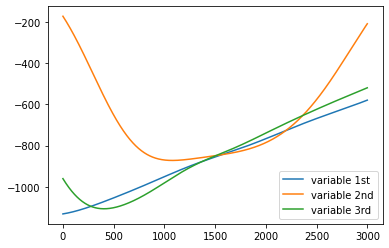

In [ ]:
plt.plot(jac0, label='variable 1st')
plt.plot(jac1, label='variable 2nd')
plt.plot(jac2, label='variable 3rd')
plt.legend()
print(max(jac0))
print(max(jac1))
print(max(jac2))